## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sean\Anaconda3

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# from day 082
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.25, 0.5]

In [7]:

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for dropoutRate in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with dropoutRate = %d" % (dropoutRate))
    
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropoutRate)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-dr-%s" % str(dropoutRate)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with dropoutRate = 0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)        

Epoch 45/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.1506 - accuracy: 0.5897 - val_loss: 1.2949 - val_accuracy: 0.5339
Epoch 46/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.1447 - accuracy: 0.5909 - val_loss: 1.2931 - val_accuracy: 0.5395
Epoch 47/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.1349 - accuracy: 0.5967 - val_loss: 1.2823 - val_accuracy: 0.5503
Epoch 48/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.1262 - accuracy: 0.5990 - val_loss: 1.3092 - val_accuracy: 0.5370
Epoch 49/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.1223 - accuracy: 0.6014 - val_loss: 1.2792 - val_accuracy: 0.5462
Epoch 50/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.1112 - accuracy: 0.6027 - val_loss: 1.2926 - val_accuracy: 0.5423
Experiment with dropoutRate = 0
Model: "model_1"
_______________________________________________________________

50000/50000 [==============================] - 3s 67us/step - loss: 1.3497 - accuracy: 0.5172 - val_loss: 1.3362 - val_accuracy: 0.5212
Epoch 41/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.3435 - accuracy: 0.5183 - val_loss: 1.3412 - val_accuracy: 0.5198
Epoch 42/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.3341 - accuracy: 0.5239 - val_loss: 1.3336 - val_accuracy: 0.5232
Epoch 43/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.3336 - accuracy: 0.5229 - val_loss: 1.3355 - val_accuracy: 0.5234
Epoch 44/50
50000/50000 [==============================] - 4s 70us/step - loss: 1.3221 - accuracy: 0.5263 - val_loss: 1.3247 - val_accuracy: 0.5249
Epoch 45/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.3162 - accuracy: 0.5299 - val_loss: 1.3292 - val_accuracy: 0.5273
Epoch 46/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.3090 - accuracy: 0.5306 - val_loss: 1.3431

50000/50000 [==============================] - 4s 74us/step - loss: 1.6516 - accuracy: 0.4072 - val_loss: 1.5268 - val_accuracy: 0.4534
Epoch 36/50
50000/50000 [==============================] - 4s 70us/step - loss: 1.6589 - accuracy: 0.4048 - val_loss: 1.5321 - val_accuracy: 0.4475
Epoch 37/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.6552 - accuracy: 0.4057 - val_loss: 1.5250 - val_accuracy: 0.4571
Epoch 38/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.6480 - accuracy: 0.4090 - val_loss: 1.5238 - val_accuracy: 0.4564
Epoch 39/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6380 - accuracy: 0.4097 - val_loss: 1.5138 - val_accuracy: 0.4605
Epoch 40/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6351 - accuracy: 0.4127 - val_loss: 1.5138 - val_accuracy: 0.4572
Epoch 41/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6316 - accuracy: 0.4117 - val_loss: 1.5071

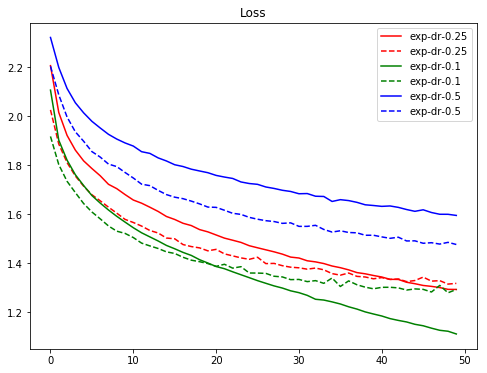

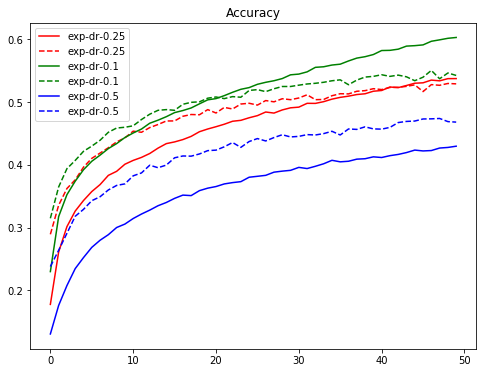

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()